## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
import pandas as pd             #For working with data as a DataFrame object
import matplotlib.pyplot as plt #For plotting visualizations
from scipy import stats
import numpy as np

In [2]:
df_raw = pd.read_csv('kc_house_data.csv') #Import data as a Pandas DataFrame

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format) #To read house prices as $ amounts instead of in scientific notation

## A first look at the raw data

In [22]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21581 entries, 0 to 21596
Data columns (total 18 columns):
price            21581 non-null float64
bedrooms         21581 non-null int64
bathrooms        21581 non-null float64
sqft_living      21581 non-null int64
sqft_lot         21581 non-null int64
floors           21581 non-null float64
waterfront       21581 non-null float64
view             21581 non-null float64
condition        21581 non-null int64
grade            21581 non-null int64
sqft_above       21581 non-null int64
sqft_basement    21581 non-null int32
yr_built         21581 non-null int64
zipcode          21581 non-null int64
lat              21581 non-null float64
long             21581 non-null float64
sqft_living15    21581 non-null int64
sqft_lot15       21581 non-null int64
dtypes: float64(7), int32(1), int64(10)
memory usage: 3.7 MB


In [ ]:
df_raw.describe()

**Observations of data summary**

ID column and date column should be dropped. Not meaningful for this exploration.

Price column initially displayed in scientific notation. Suppressed this globally so that prices can be understood as $ amounts.

The max value for bedrooms is preposterous and that row will probably need to be dropped if the rest of the data in the row doesn't describe a 33-bedroom house.

Null values will need to be filled in for waterfront, view, yr_renovated columns.

sqft_basement should be in integers to match sqft_above.

yr_renovated should be in integers to match year_built.

Some columns should be categorical; they can be transformed later.

In [ ]:
df_raw.hist(figsize=(15,15))

**Observations of histograms of each feature**

**bathrooms**: Looks not too far from a normal distribution, can probably be smoothed out. Some positive skew.

**bedrooms**: Very densely-clustered data, may need to look at another histogram with more bins after dropping outliers.

**condition**: obviously categorical

**floors**: Not categorical but not normally-distributed either. Densely-distributed around the 1-floor and 2-floor values. This makes sense as a house with with fewer than 1 floors wouldn't fit humans. Will need to be log transformed.

**Grade**: Very normally-distributed; categorical. Most houses have a "medium" grade which makes sense. The tails of the distribution will be rundown houses and fancy houses.

**id**: Not useful for this exploration. Will need to be dropped.

**lat**: Will only be useful in conjunction with longitude. Negatively skewed.

**long**: Will only be useful in conjunction with latitude. More normal-looking than lat, and positively skewed.

**price**: A few extreme outliers on the positive side are skewing the data. Extravagant mansions? Might help to drop them.

**sqft_above**: Close to a normal distribution wiht some outliers positively skewing the data.

**sqft_living**: Similar shape to sqft_above, outliers positively skewing the data.

**sqft_living15**: Even more normal than sqft_living. Probably contains fewer meaningful values.

**sqft_lot**: A few extreme outliers are positively skewing the data. Might be the same extravagant mansions.

**sqft_lot15**: Similar issue to sqft_lot. A few extreme outliers are positively skewing the data.

**view**: A categorical feature with most houses having a "0" view. Makes sense intuitively that the this data wouldn't be normally distributed: the majority of houses wouldn't have even a "medium"-grade view. They'd have no interesting view at all, just a view of other houses in their neighborhood.

**waterfront**: A categorical feature, "yes" or "no", with the vast majority of houses not being on the waterfront. Makes sense. Might be the case that dropping the extravagant mansion rows will remove most of the "yes" waterfront houses, meaning this column will need to be dropped.

**yr_built**: Negative skew towards earlier years. A spurt of new construction in the very recent past. Not sure whether to expect a normal distribution of this feature if we assume that the population of the city increases steadily from decade to decade; the bulk of the housing stock would already exist and wouldn't be replaced, but some new residents would move into new construction neighborhoods.

**yr_renovated**: If only describing renovations after 2015, then it's a categorical column.

## Cleaning the raw data

**Resetting the index**

In [4]:
df_raw = df_raw.reset_index(drop=True) #Keeps dropped rows from throwing errors later

**Dropping irrelevant columns**

In [5]:
df_raw = df_raw.drop(['id', 'date'], axis=1) #Drop the id and date columns

**Dropping the 33-bedroom house**

Let's check if there are any other over-bedroomed houses.

In [6]:
df_raw['bedrooms'].value_counts() #Check for other houses with a lot of bedrooms

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

The 10- and 11-bedroom houses also look suspicious.

In [7]:
beds_10 = df_raw[df_raw['bedrooms'] >= 10]  
beds_10

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8748,520000.00,11,3.00,3000,4960,2.00,0.00,0.00,3,7,2400,600.0,1918,1999.00,98106,47.56,-122.36,1420,4960
13301,1150000.00,10,5.25,4590,10920,1.00,0.00,2.00,3,9,2500,2090.0,2008,0.00,98004,47.59,-122.11,2730,10400
15147,650000.00,10,2.00,3610,11914,2.00,0.00,0.00,4,7,3010,600.0,1958,0.00,98006,47.57,-122.17,2040,11914
15856,640000.00,33,1.75,1620,6000,1.00,0.00,0.00,5,7,1040,580.0,1947,0.00,98103,47.69,-122.33,1330,4700
19239,660000.00,10,3.00,2920,3745,2.00,0.00,0.00,4,7,1860,1060.0,1913,0.00,98105,47.66,-122.32,1810,3745


The only house whose specs look plausible is row 13301. (5 bathrooms, price over 1 mil.) Going to drop the others.

In [8]:
df_raw = df_raw.drop([8748, 15147, 15856, 19239]) # Drop the rows with 10-or-more-bed houses

**Dropping the extravagant mansions**

Positive skew in the histogram of the price column suggests that a few extremely-high-value houses could be dropped.

In [ ]:
df_raw['price'].quantile(.99) #Return 99th percentile

99% percent of the houses in the dataset have a price under 2 million.

In [40]:
over2mil = df_raw[df_raw['price'] > 2000000]
over3mil = df_raw[df_raw['price'] > 3000000]
over4mil = df_raw[df_raw['price'] > 4000000]

print('House prices over 2 mil: ', over2mil.shape[0])
print('House prices over 3 mil: ', over3mil.shape[0])
print('House prices over 4 mil: ', over4mil.shape[0])

House prices over 2 mil:  186
House prices over 3 mil:  33
House prices over 4 mil:  0


Let's drop the most extreme outliers to reduce the positive skew of the price feature.

In [41]:
df_raw = df_raw[df_raw['price'] < 3000000] #Drop rows with price over 3 mil

**Filling in null values for waterfront**

How many null values?

In [45]:
df_raw['waterfront'].isna().sum() #Every null value is returned as False; add up the Falses for total of nulls

0

It's safe to assume these 2376 houses do not front the water. Let's fill them with 0. Later they'll be converted to a categorical value.

In [10]:
df_raw['waterfront'] = df_raw['waterfront'].fillna(0) #Fill null values with 0, i.e. "Is waterfront = False"

**Filling in null values for view**

How many null values are there, and which other value is the most reasonable to fill them with?

In [46]:
print(df_raw['view'].value_counts()) #Returns the sum of the observations of each value in the column
print('\n')
print('Total nulls: ', df_raw['view'].isna().sum())

0.00    19465
2.00      953
3.00      506
1.00      328
4.00      290
Name: view, dtype: int64


Total nulls:  0


Most houses have a "0" view. That's a pity. We can assume the 62 nulls also have a "0" view.

In [11]:
df_raw['view'] = df_raw['view'].fillna(0)

**Filling in null values for yr_renovated**

How many rows have a yr_renovated value that isn't 0 or null?

In [47]:
yr_rn_total = df_raw.shape[0] #Total number of rows in yr_renovated
yr_rn_zeros = df_raw[df_raw['yr_renovated'] == 0.00].shape[0] #Number of 0 values in yr_renovated
yr_rn_nulls = df_raw['yr_renovated'].isna().sum() #Number of nulls in yr_renovated

print('Rows in yr_renovated: ', yr_rn_total)
print('Zero values: ', yr_rn_zeros)
print('Null values: ', yr_rn_nulls)
print('Non-zero, non-null values: ', (yr_rn_total - yr_rn_zeros - yr_rn_nulls))

KeyError: 'yr_renovated'

Not enough useful values for the column to be useful. Let's drop it.

In [12]:
df_raw = df_raw.drop(['yr_renovated'], axis=1) #Drop the yr_renovated column

**Converting sqft_basement to integers**

In [20]:
df_raw['sqft_basement'].head(6)

0       0
1     400
2       0
3     910
4       0
5    1530
Name: sqft_basement, dtype: int32

In [17]:
type(df_raw['sqft_basement'][1]) #Looks like the float 400.0 but is actually the str'400.0'

str

This column is riddled with '?'s and values that look numerical but are actually strings. Let's replace '?' with 0, and convert the fake number strings into floats, and then into integers.

In [18]:
df_raw['sqft_basement'] = df_raw['sqft_basement'].replace('?', 0)
df_raw['sqft_basement'] = df_raw['sqft_basement'].astype('float') #Must convert strings to floats first
df_raw['sqft_basement'] = df_raw['sqft_basement'].astype('int') #Then convert the floats to integers

## A second look

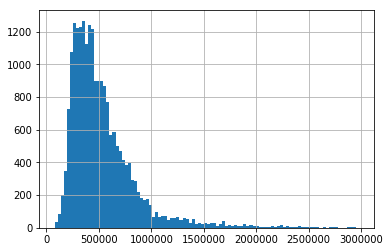

In [44]:
df_raw['price'].hist(bins=100)

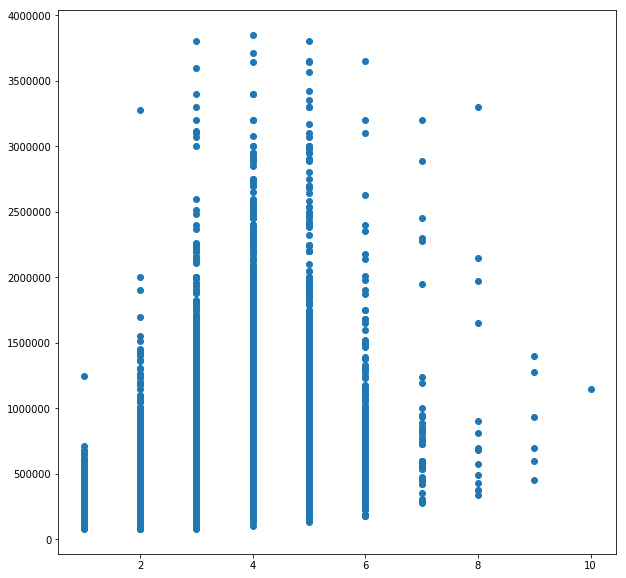

In [39]:
columns_for_hist = ['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'price', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15']

plt.figure(figsize=(10,10))
plt.scatter(df_raw['bedrooms'], df_raw['price'])
plt.show()

In [ ]:
#BoxCox experiment

plt.hist(df_raw['sqft_living'], bins=50)

In [ ]:
transform = np.asarray(df_raw[['sqft_living']].values)

In [ ]:
dft = stats.boxcox(transform)[0]

In [ ]:
plt.hist(dft, bins=50)
plt.show()

### Log transformations

### Feature scaling

### Converting categorical variables

In [ ]:
#should be categoricals: bedrooms? bathrooms? floors? grade (what is grade?), waterfront, view, zip code

In [ ]:
print(df_raw['bedrooms'].value_counts())
#10       3     seems plausible, maybe just very valuable houses
#11       1     might be a typo of 1
#33       1     might be a typo of 3
#print(df_raw['bathrooms'].value_counts())
#print(df_raw['floors'].value_counts())
#print(df_raw['waterfront'].value_counts())
#print(df_raw['view'].value_counts())
#print(df_raw['grade'].value_counts())
#print(df_raw['zipcode'].value_counts())

In [ ]:
#bedrooms, bathrooms, floors: NOT categorical
#waterfront: categorical
#view: categorical
#grade: categorical
#zipcode: technically categorical, but will it complicate the data to add 70 dummy columns?

### Cleaning data
1.  A list
2.  of things
3.  in markdown
itting data with logs

**Cleaned data**

In [ ]:
df #final version of dataframe

**Iterative regression**


**ordinary least squares**
use smf.ols
build a formula to put into the function



**recursive feature elimination** 
    Import RFE from sklearn
    make a for loop to run linreg on the data with first 1 feature, then several, then several more, &c. Set up a range with numpy from 1 to the total number of features, going up by 10 or so
    will start to overfit as more features are added
    Compare r square and r square adjusted
    Values will get higher as model gets more accurate (approaching 1 from 0)
    
**train test split**
    Import train test split from sklearn
    Function takes 4 variables
    Perform linreg on the train set and the test set, then compare:
    Calculate MSEs for both train results and test results
    Value will get smaller as model gets more accurate (error gets closer to 0)


**k fold cross validation**
    Pick best features to use by calling RFE
    Call cross_val_score with linreg, X, and y, and choose  a number of folds.
    Returns an array of negative MSEs
    If there are a lot of dummy/categorical variable columns, some MSEs in the resulting array will have weird results. If so, use fewer predictors.
holdout validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

docstrings for original functions
map with longitudes/latitudes?
what is "grade" -- look at king county

good summary of linear regression in python at https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606

In [ ]:
Saving this in case it comes up again:
    df_raw.loc[0, 'sqft_basement'] = 0 #Correct way to insert a value into a df without chain indexing